In [38]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import random
from sklearn.datasets import load_digits
import torch
import torch.nn.functional as F
import math

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [39]:
class Layer: 
    def __init__ (self, Id, Od, p_active, final = False):
        self.W = (torch.randn(Od, Id) *  math.sqrt(2/Id)).to(device)
        self.dW = torch.zeros_like(self.W).to(device)
        
        (self.B, self.dB, self.dB_rms, self.dB_vel, self.C, self.dC, self.dC_rms, 
        self.dC_vel, self.V_avg, self.C_avg, self.dV, self.dV_rms, self.dV_vel) = [torch.zeros(Od, 1).to(device) for _ in range (0,13)]
        self.p = p_active
        
        self.V = torch.ones_like(self.C).to(device)
        
        self.cache = {}
        self.dA_prev = None
        self.final = final 
        
        def opt(self, opt_params):
            f.optimize(self, opt_params)
        
        def fp (self, A_prev, Y):
            if self.final:
                f.fin_fprop(self, A_prev, Y)
            else:
                f.fprop(self, A_prev, Y)
        
        def bp (self, dA, Y): 
            if self.final:
                f.fin_bprop(self, dA, Y)
            else:
                f.bprop(self, dA, Y)
        
        def test_fp(self, A_prev, Y):
            fp(self, A_prev, Y)

In [40]:
class f: 
    @staticmethod
    def prelu (Z,p): 
        return torch.where(Z>0, Z, p * Z)
        
    @staticmethod
    def prelu_grad (Z,p): 
        return torch.where(Z>0, 1, p) 
        
    @staticmethod
    def softmax (Z): 
        Z_exp = torch.exp(Z - torch.max(Z))
        return Z_exp/torch.sum(Z_exp, dim = 0, keepdim = True)
        
    @staticmethod
    def crossENT (A,Y): 
        m = A.shape[1]
        L = -torch.sum(Y * torch.log(A), dim = 0, keepdim = True)
        J = torch.sum(L)/m 
        return J
    
    @staticmethod
    def fprop (layer, A_prev, Y):
        e = 0.0000000000001
        Z = (torch.matmul(layer.W, A_prev) + layer.B).to(device)
        mean = torch.mean(Z, dim = 1, keepdim = True).to(device)
        std = (torch.std(Z, dim = 1, keepdim = True) + e).to(device)
        Z_ = ((Z - mean)/std).to(device)
        H = ((layer.V * Z_) + layer.C).to(device)
        A = (f.prelu(H, layer.p)).to(device)
        layer.cache = {'A_prev': A_prev.to(device),
                       'Z' : Z,
                       'std': std,
                       'H': H,
                       'Z_': Z_,
                       'A' : A
                      }
        
    @staticmethod
    def fin_fprop (layer, A_prev, Y):
        e = 0.0000000000001
        Z = (torch.matmul(layer.W, A_prev) + layer.B).to(device)
        mean = torch.mean(Z, dim = 1, keepdim = True).to(device)
        std = (torch.std(Z, dim = 1, keepdim = True) + e).to(device)
        Z_ = ((Z - mean)/std).to(device)
        H = ((layer.V * Z_) + layer.C).to(device)
        A = (f.softmax(H, layer.p)).to(device)
        layer.cache = {'A_prev': A_prev.to(device),
                       'Z' : Z,
                       'std': std,
                       'H': H,
                       'Z_': Z_,
                       'A' : A
                      }
        self.cost = f.crossENT(A, Y)
        
    @staticmethod
    def bprop (layers, dA, Y):
            A_prev = layer.cache['A_prev'].to(device)
            Z = layer.cache['Z'].to(device)
            Z_ = layer.cache['Z_'].to(device)
            A = layer.cache['A'].to(device)
            m = A_prev.shape[1]
            std = layer.cahse['std'].to(device)
            dH = (dA * f.prelu_grad(H, layer.p)).to(device)
            layer.dV = torch.sum((Z_ * dH), dim = 1, keepdim = True)
            layer.dC = torch.sum(dH, dim = 1, keepdim = True)
            dZ_ = (layer.V * dH).to(device)
            dZ = (((m*dZ_) - (torch.sum(dZ_, dim = 1, keepdim = True)) - (Z_ * (toch.sum((Z_ * dZ_), dim = 1, keepdims = True))))/(m * std)).to(device)
            layer.dW = torch.matmul(dZ, A_prev.permute(1, 0))
            layer.dB = torch.sum(dZ, dim = 1, keepdim = True)
            layer.dA_prev = torch.matmul(W.permute(1, 0), dZ)
                             
    @staticmethod
    def fin_bprop (layers, dA, Y):
            A_prev = layer.cache['A_prev'].to(device)
            Z = layer.cache['Z'].to(device)
            Z_ = layer.cache['Z_'].to(device)
            A = layer.cache['A'].to(device)
            m = A_prev.shape[1]
            std = layer.cache['std'].to(device)
            dH = ((A - Y)/m).to(device)
            layer.dV = torch.sum((Z_ * dH), dim = 1, keepdim = True)
            layer.dC = torch.sum(dH, dim = 1, keepdim = True)
            dZ_ = (layer.V * dH).to(device)
            dZ = (((m*dZ_) - (torch.sum(dZ_, dim = 1, keepdim = True)) - (Z_ * (toch.sum((Z_ * dZ_), dim = 1, keepdims = True))))/(m * std)).to(device)
            layer.dW = torch.matmul(dZ, A_prev.permute(1, 0))
            layer.dB = torch.sum(dZ, dim = 1, keepdim = True)
            layer.dA_prev = torch.matmul(W.permute(1, 0), dZ)
    
    @staticmethod
    def lr_decay(t, alpha_0):
        alph = alpha_0
        return alph
    
    @staticmethod
    def optimize(layers, opt_params):
        alpha_0 = opt_params['alpha_0']
        t = opt_params['t']
        alpha = f.lr_decay(t, alpha_0)
        beta_dW, beta_dW0 = opt_params['beta_dW'] 
        beta_dB, beta_dB0 = opt_params['beta_dB']
        beta_dC, beta_dC0 = opt_params['beta_dC']
        theta_C = opt_params['theta_C']
        theta_V = opt_params['theta_V']
        
        layer.dB_vel = (((beta_dB) * (layer.dB_vel)) + ((1-Beta_dB) * (layer.dB)))/(1 - (beta_dB ** t))
        layer.dB_rms = (((beta_dB0) * (layer.dB_vel)) + ((1-Beta_dB0) * ((layer.dB) ** 2)))/(1 - (beta_dB0 ** t))
                                                        
        layer.dW_vel = (((beta_dW) * (layer.dW_vel)) + ((1-Beta_dW) * (layer.dW)))/(1 - (beta_dW ** t))
        layer.dW_rms = (((beta_dW0) * (layer.dW_vel)) + ((1-Beta_dW0) * ((layer.dW) ** 2)))/(1 - (beta_dW0 ** t))
                                                        
        layer.dV_vel = (((beta_dV) * (layer.dV_vel)) + ((1-Beta_dV) * (layer.dV)))/(1 - (beta_dV ** t))
        layer.dV_rms = (((beta_dV0) * (layer.dV_vel)) + ((1-Beta_dV0) * ((layer.dV) ** 2)))/(1 - (beta_dV0 ** t))
                                                        
        layer.dC_vel = (((beta_dC) * (layer.dC_vel)) + ((1-Beta_dC) * (layer.dC)))/(1 - (beta_dC ** t))
        layer.dC_rms = (((beta_dC0) * (layer.dC_vel)) + ((1-Beta_dC0) * ((layer.dC) ** 2)))/(1 - (beta_dC0 ** t))
                                                        
        layer.V_avg = (((theta_V) * (layer.V_avg)) + ((1 - theta_V) * (layer.V)))/(1 - (theta_V ** t))
        layer.C_avg = (((theta_C) * (layer.C_avg)) + ((1 - theta_C) * (layer.C)))/(1 - (theta_C ** t))
        
        layer.W -= (alpha) * (layer.dW_vel/torch.sqrt(layer.dW_rms))
        layer.B-= (alpha) * (layer.dB_vel/torch.sqrt(layer.dB_rms))
        layer.V -= (alpha) * (layer.dV_vel/torch.sqrt(layer.dV_rms))
        layer.C -= (alpha) * (layer.dC_vel/torch.sqrt(layer.dC_rms))

In [41]:
class TF:
    @staticmethod
    def fprop(layer, A_prev, Y):
        e = 1e-8  # Small epsilon to avoid division by zero
        device = A_prev.device
        
        # Forward pass
        Z = torch.matmul(layer.W, A_prev) + layer.B  # Linear transformation
        mean = torch.mean(Z, dim=1, keepdim=True)    # Mean across the first dimension (features)
        std = torch.std(Z, dim=1, keepdim=True) + e  # Standard deviation (with epsilon)
        Z_ = (Z - mean) / std                        # Normalization
        
        H = layer.V * Z_ + layer.C                   # Scale and shift
        A = F.prelu(H, layer.p)                      # PReLU activation
        
        # Caching results for backpropagation
        layer.cache = {'A_prev': A_prev, 'Z': Z, 'mean': mean, 'std': std, 'Z_': Z_, 'H': H, 'A': A}
        
        return A

In [42]:
class Model: 
    def __init__ (self, A0_dim, AL_dim, HL_dims, p_activ): 
        self.L_dims = [A0_dim] + HL_dims + [AL_dim]
        self.n = len(self.L_dims)
        self.layers = [0]
        self.layers += [Layer(self.L_dims[i-1], self.L_dims[i], p_activ, final = False) for i in range (1, self.n - 1)]
        self.layers += [Layer(self.L_dims[self.n - 2], self.L_dims[self.n - 1], p_activ, final = True)]

    def forward(self, X, Y):
        A_prev = X
        for i in range(1, self.n): 
            
            self.layers[i].fp(A_prev, Y)
            A_prev = self.layers[i].cache['A']
            #self.fp = F.fprop(self, A_prev, Y) 
    def backward(self, X, Y): 
        dA = None 
        for i in reversed(range(1, self.n)): 
            self.layers[i].bp(dA, Y)
            dA = self.layers[i].dA_prev

    def gradient_descent(self, alph): 
        for i in range(1, self.n): 
            self.layers[i].opt(opt_params)

    def training_epoch (self, opt_params, X_train_batches, Y_train_batches, printCost = False):
        bs = len(X_train_batches)
        for t in range (0,bs): 
            X_train = X_train_batches[t]
            Y_train = Y_train_batches[t]
            
            self.forward(X_train, Y_train)
            self.backward(X_train, Y_train)
            self.gradient_descent(alph)
            if printCost:
                print(self.layers[self.n-1].cost)
        
    def predict (self, X, Y): 
        self.forward(X, Y)
        self.V = self.V_avg
        fin_act = self.layers[self.n - 1].cache['A']
        pred = torch.zeros_like(fin_act)
        max_indices = torch.argmax(fin_act, dim=0)
        pred.scatter_(0, max_indices.unsqueeze(0), 1)
        return pred

In [43]:
torch.manual_seed(42)

# If using CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

test_layer = Layer(3, 3, 0.3)
test_layer.B = torch.tensor([0.1, 0.2, 0.3])
test_layer.C = torch.tensor([0.02, 0.05, 0.04])
test_layer.V = torch.tensor([0.22, 0.33, 0.212])
A_prev = torch.tensor([[0.02, 0.04, 0.16], [0.04, 0.07, 0.11], [0.03, 0.03, 0.14]]).to(device)
Y = torch.tensor([[0, 1, 0], [1, 0, 1], [0, 0, 1]]).to(device)

(1797, 64)
3


<Figure size 640x480 with 0 Axes>

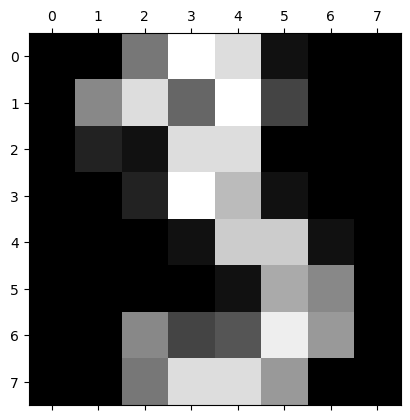

[ 0.          8.3369963   1.55676159  0.62348292  0.84159189  1.70138742
  1.91442295 -0.12563545 -0.05955753  2.115924    0.92413236  0.90805457
  0.50629541  0.40505773  0.82922685 -0.13061034 -0.04412544  0.89297863
  0.9797157   0.834688   -1.15705571 -1.26139189 -0.54774412 -0.11488858
 -0.0333373  -0.47891083  0.71963665  0.82522503 -1.61198076 -1.28551251
 -0.63110674 -0.04722047  0.         -0.67669173  0.01640613  1.04693235
 -1.41038664 -1.49274895 -0.826222    0.         -0.06161515 -0.53487254
  0.14031329  1.15830787 -1.22976866 -1.45846214 -0.79583077 -0.08996861
 -0.03590278  1.27829872  1.0757585   0.22534197 -1.80482941 -1.45713418
 -0.75553924 -0.21234332 -0.02359584  9.1623548   1.94719509 -1.42523668
 -2.37326603 -1.14176155 -0.50519614 -0.19619223]
(64, 1500)
(64, 200)
(64, 97)
(1797,)
(1797, 10)
0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(10, 1500)
(10, 200)
(10, 97)


In [44]:
# Load dataset
digits = load_digits()

# Print dataset shape and target for the second sample
print(digits.data.shape)
print(digits.target[3])

# Visualize the image of the second sample
plt.gray()
plt.matshow(digits.images[3])
plt.show()

# Shuffle the data, keeping the corespondence between feature vector and it's label
np.random.seed(1)
data_, target_ = shuffle(digits.data, digits.target)

#normalization

X_prev = data_/np.linalg.norm(data_, axis = 1, keepdims = True)
m = X_prev.shape[0]
e = 0.00000001 #numerical stability
X_prev_mean = np.sum(X_prev, axis = 0, keepdims = True)/m
X_prev_deviation = np.sqrt(np.sum((X_prev - X_prev_mean)**2, axis = 0, keepdims = True)/m)
X_ = (X_prev - X_prev_mean)/(X_prev_deviation + e)
#check that normalization works
print(X_[1])
#we will take the first 1500 examples for training, the 200 examples for development, and the last 97 examples for test.
#we will also transpose the matrix, so that our features are column vectors instead of row vectors.
X_train = X_[:1500].T
print(X_train.shape)
X_dev = X_[1500:1700].T
print(X_dev.shape)
X_test = X_[1700:].T
print(X_test.shape)
#we see that now, the feature vectors are columns of our matrices, X_train, X_dev, X_test.

Y_ = target_
print(Y_.shape)
num_classes = int(10) 
# we will initialize so that first we have 10 rows, then transpose, as usual. 
Y = np.zeros((Y_.shape[0], num_classes))
print(Y.shape)
#we will perform one hot encoding now. 
row_indices = np.arange(Y_.shape[0])
Y[row_indices, Y_] = 1
#it is clear that our one hot encoding works
print(f"{Y_[5]} -> {Y[5]}")
#now, we do the same train, test, dev, split on Y, and also transpose to ensure our ground truth vectors are columns
Y_train = Y[:1500].T
print(Y_train.shape)
Y_dev = Y[1500:1700].T
print(Y_dev.shape)
Y_test = Y[1700:].T
print(Y_test.shape)

class Data: 
    def __init__ (self, X_train, X_dev, X_test, Y_train, Y_dev, Y_test): 
        self.XT_batches = []
        self.YT_batches = []
        batch_size = 300
        for i in range(1, 6): 
            start_idx = (i - 1) * batch_size
            end_idx = i * batch_size
            self.XT_batches.append(X_train[:, start_idx:end_idx])
            self.YT_batches.append(Y_train[:, start_idx:end_idx])
            
        self.X_dev = X_dev
        self.Y_dev = Y_dev
        self.X_test = X_test
        self.Y_test = Y_test
        self.A0_dims = X_train.shape[0]
        self.AL_dims = Y_train.shape[0]

data = Data(X_train, X_dev, X_test, Y_train, Y_dev, Y_test)

In [45]:
# Assuming `data` is an object with attributes A0_dims and AL_dims
q = int(data.A0_dims)
A0 = int(data.A0_dims)
AL = int(data.AL_dims)

# Seed for reproducibility
torch.manual_seed(6)
n = 5

# Initialize hidden layer dimensions (HL_dims) randomly
HL_dims = torch.randint(q - 10, q + 10, (n,)).tolist()
# Reset seed to 1 for consistency
torch.manual_seed(1)

# Assuming you have a Model class defined to create the model
classif = Model(A0, AL, HL_dims, 0.3)

In [46]:
for t in range (0, 10):
    
    opt_params = {'alph_0' : 0.001, 't' : t, 'beta_dW' : (0.9, 0.999), 
               'beta_dB' : (0.9, 0.999), 'beta_dC' : (0.9, 0.999), 
               'beta_dV' : (0.9, 0.999), 'theta_C' : 0.9, 'theta_V' : 0.9}
    
    classif.training_epoch (opt_params, data.XT_batches, data.YT_batches, printCost = True)

AttributeError: 'Layer' object has no attribute 'fp'